In [1]:
!pip install spacy



In [2]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy
import matplotlib.pyplot as plt

import seaborn as sns


In [3]:
# Load the spaCy language model
nlp = spacy.load("en_core_web_sm")

In [4]:
data1 = pd.read_excel("filtered_data.xlsx", usecols=['tweets', 'class'])
data1.head()

,tweets,class
0,'Disrespected the wife of Prophet' - pseudo li...,irony
1,Looking forward to next week and stepping away...,irony
2,Get to work to realize oatmeal packet I grabbe...,irony
3,@WeirdToBe waise what blocking means to nida i...,irony
4,@JillHS23 He has stated he wants to 'destroy t...,irony


Handled the Duplication and Inconsistencies

Insights from EDA- Duplicate values:

Out of 13,381 tweets, all duplicates marked as sarcasm have a copy marked as figurative.
Similarly, all duplicates marked as irony are also marked as FIGURATIVE.
There are an additional 13,418 rows when sarcasm and irony row counts are added.
Thus, there are 37 additional duplicates in sarcasm or irony or regular apart from figurative.
18 rows contain only irony. Only 1 seems to be a relevant ironic statement.
Example: "Some girls want to be treated like queens but they do not know how to be one. #irony"
This has 9 duplicate values out of the 18.
The others are marked as #ironic, #irony, etc.
There are 5 rows marked as #sarcasm with class "sarcasm" and 4 duplicate values.
Actions to Take:

Remove the 5 rows marked as #sarcasm with class "sarcasm".
For the 50 regular tweets, remove duplicates as the same tweets have been reposted.
For the remaining 13,382 tweets tagged as figurative, sarcasm, and irony, combine them under the figurative class and then remove duplicates.
In other words, keep the figurative class tweets.
Final Insights:

After processing, there will be a total of 13,469 actionable rows.
For the 50 regular tweets, we will remove duplicates.
For the 13,382 tweets tagged as figurative, sarcasm, and irony combined, we will keep the figurative class and remove duplicates.
There are 37 remaining rows with irony or sarcasm where duplicates can be removed.







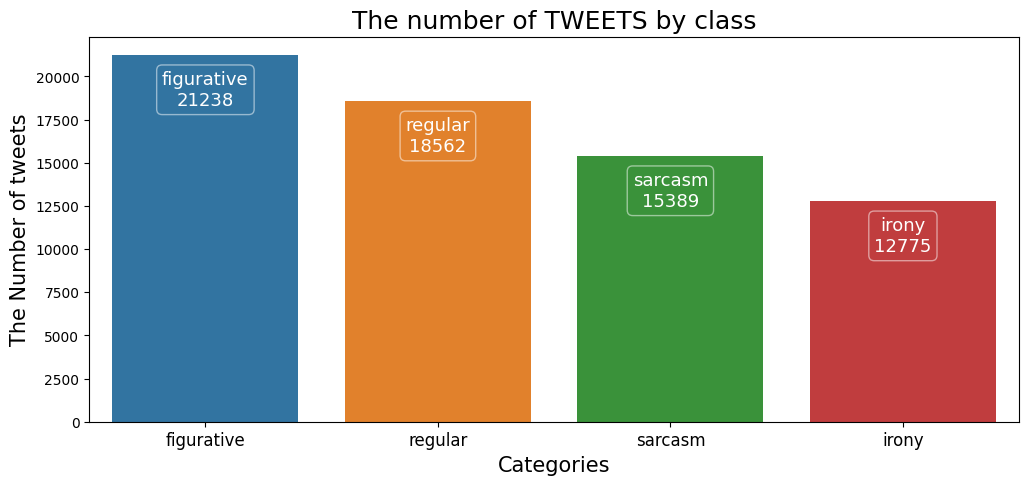

In [5]:
# Bar plot for each of the new category
category_count = data1['class'].value_counts()

categories = category_count.index
data1['class'].value_counts()
fig = plt.figure(figsize= (12, 5))

ax = fig.add_subplot(111)

sns.barplot(x = category_count.index, y = category_count )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )

plt.xlabel('Categories', size = 15)

plt.ylabel('The Number of tweets', size= 15)

plt.xticks(size = 12)

plt.title("The number of TWEETS by class" , size = 18)

plt.show()



1.   The business decision is to retain the figurative records and remove the irony and sarcasm classes.
2.   After removing duplicates, the dataset has highly unbalanced classes.




In [6]:
import re
import numpy as np
def remove_pattern(text, exp):
    if isinstance(text, str):
        r = re.findall(exp, text)
        for i in r:
            text = re.sub(re.escape(i), "", text)
        return text
    else:
        return ""

In [7]:
#removal of @
data1['clean_tweets']=np.vectorize(remove_pattern)(data1['tweets'],"@[\w]*")
#removal of Https
data1['clean_tweets']=np.vectorize(remove_pattern)(data1['clean_tweets'],"https[\S]*")
data1['clean_tweets']=np.vectorize(remove_pattern)(data1['clean_tweets'],"http[\S]*")
#removal of #
data1['clean_tweets']=np.vectorize(remove_pattern)(data1['clean_tweets'],"#")
# Define words to remove for figurative class (class 1)
words_to_remove = ['sarcasm', 'irony','ironic','sarcastic']

# Apply word removal only to rows with class 1
data1['clean_tweets'][data1['class'] == 'figurative'] = data1[data1['class'] == 'figurative']['clean_tweets'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in words_to_remove]))

data1.to_excel('cleantweets.xlsx', index=False)

In [8]:
import string
#removing the punctation
pun=string.punctuation
pun

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [9]:
for i in range(0,len(data1['clean_tweets'])):
  text=data1['clean_tweets'][i]
  no_pun=[char for char in text if char not in pun]
  no_pun=''.join(no_pun)
  data1['clean_tweets'][i]=no_pun

data1.head()


,tweets,class,clean_tweets
0,'Disrespected the wife of Prophet' - pseudo li...,irony,Disrespected the wife of Prophet pseudo libta...
1,Looking forward to next week and stepping away...,irony,Looking forward to next week and stepping away...
2,Get to work to realize oatmeal packet I grabbe...,irony,Get to work to realize oatmeal packet I grabbe...
3,@WeirdToBe waise what blocking means to nida i...,irony,waise what blocking means to nida is awesome ...
4,@JillHS23 He has stated he wants to 'destroy t...,irony,He has stated he wants to destroy the IS Cali...


In [10]:
# remove both the leading and the trailing characters
data1['clean_tweets']=[x.strip() for x in data1.clean_tweets]
#data1['clean_tweets']=[x for x in data1.clean_tweets if x]
data1.head()


,tweets,class,clean_tweets
0,'Disrespected the wife of Prophet' - pseudo li...,irony,Disrespected the wife of Prophet pseudo libta...
1,Looking forward to next week and stepping away...,irony,Looking forward to next week and stepping away...
2,Get to work to realize oatmeal packet I grabbe...,irony,Get to work to realize oatmeal packet I grabbe...
3,@WeirdToBe waise what blocking means to nida i...,irony,waise what blocking means to nida is awesome i...
4,@JillHS23 He has stated he wants to 'destroy t...,irony,He has stated he wants to destroy the IS Calip...


In [12]:
import spacy
from tqdm import tqdm

# Load the spaCy language model
nlp = spacy.load("en_core_web_sm")

# Assuming you have a DataFrame named data1 with 'clean_tweets' and 'word_token' columns

# Define the preprocess function using spaCy tokenizer
def preprocess_text(text):
    # Tokenize using spaCy
    tokens = [token.text for token in nlp(text)]
    return tokens

# Apply the preprocess function to the 'clean_tweets' column with tqdm
tqdm.pandas()  # Initialize tqdm for pandas apply
data1['word_token'] = data1['clean_tweets'].progress_apply(preprocess_text)

# Convert text to lowercase
data1['clean_tweets'] = data1['clean_tweets'].apply(lambda x: x.lower())

# Convert tokens to lowercase
data1['word_token'] = data1['word_token'].apply(lambda x: [word.lower() for word in x])

# Lemmatize using spaCy
data1['lemmatized'] = data1['word_token'].apply(lambda x: [token.lemma_ for token in nlp(" ".join(x))])



100%|██████████| 67964/67964 [11:41<00:00, 96.88it/s]


KeyboardInterrupt: ignored

In [13]:

# Display the updated DataFrame
data1.head()

,tweets,class,clean_tweets,word_token
0,'Disrespected the wife of Prophet' - pseudo li...,irony,disrespected the wife of prophet pseudo libta...,"[disrespected, the, wife, of, prophet, , pseu..."
1,Looking forward to next week and stepping away...,irony,looking forward to next week and stepping away...,"[looking, forward, to, next, week, and, steppi..."
2,Get to work to realize oatmeal packet I grabbe...,irony,get to work to realize oatmeal packet i grabbe...,"[get, to, work, to, realize, oatmeal, packet, ..."
3,@WeirdToBe waise what blocking means to nida i...,irony,waise what blocking means to nida is awesome i...,"[waise, what, blocking, means, to, nida, is, a..."
4,@JillHS23 He has stated he wants to 'destroy t...,irony,he has stated he wants to destroy the is calip...,"[he, has, stated, he, wants, to, destroy, the,..."


In [14]:
data1.shape

(67964, 4)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import pandas as pd

# Create a TfidfVectorizer instance with standard English stopwords
tfidf_sar = TfidfVectorizer(norm="l1", analyzer='word', ngram_range=(1, 2), max_features=500, stop_words='english')

# Fit and transform the text data with tqdm
X = tfidf_sar.fit_transform(tqdm(data1['clean_tweets'], desc="TF-IDF Transformation"))

# Sum the TF-IDF scores for each word across all documents
sum_words = X.sum(axis=0)

# Create a list of (word, TF-IDF sum) tuples, excluding "not"
words_freq = [(word, sum_words[0, tfidf_sar.vocabulary_[word]]) for word in tfidf_sar.vocabulary_ if word != "not"]

# Sort the words by their TF-IDF sums in descending order
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

# Create a DataFrame from the sorted list of word frequencies
wd_df = pd.DataFrame(words_freq, columns=['word', 'weight'])

# Save the DataFrame to a CSV file
wd_df.to_csv("tweets_ngram_tfidf.csv", index=False)

# Display the top 10 words with their TF-IDF scores
print(wd_df.head(10))


TF-IDF Transformation: 100%|██████████| 67964/67964 [00:01<00:00, 38998.03it/s]


       word       weight
0   sarcasm  3246.211573
1     irony  2656.280004
2      news  1058.526845
3    ironic   986.445463
4     peace   974.011025
5     drugs   960.123110
6      late   893.635945
7     humor   835.872884
8      just   816.330321
9  politics   802.184371


TfidfVectorizer (Term Frequency-Inverse Document Frequency):

It calculates a normalized value that takes into account both the frequency of a word in a document and its importance in the entire corpus.
It assigns higher weights to words that are more unique to a document, while penalizing words that are common across many documents.
It's particularly useful for tasks like information retrieval, text clustering, and recommendation systems, where you want to capture

In [16]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data1['class_encoded'] = label_encoder.fit_transform(data1['class'])


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, data1['class_encoded'], test_size=0.2, random_state=42, stratify=data1['class_encoded']
)



In [18]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create and train the XGBoost model with hyperparameters
best_model = XGBClassifier(
    n_estimators=20,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
  )

# Train the model and monitor cost function optimization
best_model.fit(X_train, y_train, verbose=False)

# Make predictions on the training set
y_train_pred = best_model.predict(X_train)

# Calculate training accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Best Model Training Accuracy:", train_accuracy)

# Make predictions on the test set
y_test_pred = best_model.predict(X_test)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Best Model Test Accuracy:", test_accuracy)

# Decode the encoded class labels back to actual class names
y_test_actual = label_encoder.inverse_transform(y_test)
y_pred_actual = label_encoder.inverse_transform(y_test_pred)

# Generate classification report for the test set
report = classification_report(y_test_actual, y_pred_actual)
print("Classification Report:\n", report)

Best Model Training Accuracy: 0.9893693329164445
Best Model Test Accuracy: 0.9876406974177886
Classification Report:
               precision    recall  f1-score   support

  figurative       1.00      0.96      0.98      4248
       irony       0.99      1.00      1.00      2555
     regular       0.97      1.00      0.98      3712
     sarcasm       0.99      1.00      1.00      3078

    accuracy                           0.99     13593
   macro avg       0.99      0.99      0.99     13593
weighted avg       0.99      0.99      0.99     13593



In [20]:
import joblib

# Save the trained model to a file
joblib.dump(best_model, 'xgboost_model.pkl')


['xgboost_model.pkl']

In [21]:
# Assuming you have a label encoder named label_encoder
joblib.dump(label_encoder, 'label_encoder.pkl')


['label_encoder.pkl']